In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import random
import time
import math
import d2l
import os

from mxnet import autograd, np, npx, gluon, init
from mxnet.gluon import loss as gloss
from mxnet.gluon import nn
npx.set_np()

#  07. Modern Convolutional Neural Networks
Now that we understand the basics of wiring together convolutional neural networks, we will take you through a tour of modern deep learning. In this chapter, each section will correspond to a significant neural network architecture that was at some point (or currently) the base model upon which an enormous amount of research and projects were built. Each of these networks was at briefly a dominant architecture and many were at one point winners or runners-up in the famous `ImageNet` competition, which has served as a barometer of progress on supervised learning in computer vision since 2010.

These models include 
+ `AlexNet`: the first large-scale network deployed to beat conventional computer vision methods on a large-scale vision challenge; 
+ `VGG`: makes use of a number of repeating blocks of elements
+ `NiN`: network in network, which convolves whole neural networks patch-wise over inputs
+ `GoogLeNet`: makes use of networks with parallel concatenations
+ `ResNet`: residual networks, which are the most popular go-to architecture today
+ `DenseNet`: densely connected networks, which are expensive to compute but have set some recent benchmarks


## 7.6 Residual Networks (ResNet)
As we design increasingly deeper networks it becomes imperative to understand how adding layers can increase the complexity and expressiveness of the network. Even more important is the ability to design networks where adding layers makes networks strictly more expressive rather than just different. To make some progress we need a bit of theory.

### 7.6.1 Function Classes
Consider $\mathcal{F}$, the class of functions that a specific network architecture (together with learning rates and other hyperparameter settings) can reach. That is, for all $f \in \mathcal{F}$ there exists some set of parameters $W$ that can be obtained through training on a suitable dataset. Let us assume that $f^*$ is the function that we really would like to find. If it is in $\mathcal{F}$, we are in good shape but typically we will not be quite so lucky. Instead, we will try to find some $f^*_\mathcal{F}$ which is our best bet within $\mathcal{F}$. For instance, we might try finding it by solving the following optimization problem:
$$f^*_\mathcal{F} := \mathop{\mathrm{argmin}}_f L(X, Y, f) \text{ subject to } f \in \mathcal{F}.$$

It is only reasonable to assume that if we design a different and more powerful architecture $\mathcal{F}'$ we should arrive at a better outcome. In other words, we would expect that $f^*_{\mathcal{F}'}$ is "better" than $f^{\mathcal{F}}$. However, if $\mathcal{F} \not\subseteq \mathcal{F}'$ there is no guarantee that this should even happen. In fact, $f^*_{\mathcal{F}'}$ might well be worse. This is a situation that we often encounter in practice---adding layers does not only make the network more expressive, it also changes it in sometimes not quite so predictable ways. `Fig. 7.6.1` illustrates this in slightly abstract terms.

<img src="images/07_07.png" style="width:600px;"/>

Only if larger function classes contain the smaller ones are we guaranteed that increasing them strictly increases the expressive power of the network. This is the question that `He et al, 2016` considered when working on very deep computer vision models. At the heart of `ResNet` is the idea that every additional layer should contain the identity function as one of its elements. This means that if we can train the newly-added layer into an identity mapping $f(\mathbf{x}) = \mathbf{x}$, the new model will be as effective as the original model. As the new model may get a better solution to fit the training dataset, the added layer might make it easier to reduce training errors. Even better, the identity function rather than the null $f(\mathbf{x}) = 0$ should be the simplest function within a layer.

These considerations are rather profound but they led to a surprisingly simple solution, a **residual block**. With it, (`He et al., 2016a`) won the ImageNet Visual Recognition Challenge in 2015. The design had a profound influence on how to build deep neural networks.

### 7.6.2 Residual Blocks
Let us focus on a local neural network, as depicted below. Denote the input by $\mathbf{x}$. We assume that the ideal mapping we want to obtain by learning is $f(\mathbf{x})$, to be used as the input to the activation function. The portion within the dotted-line box in the left image must directly fit the mapping $f(\mathbf{x})$. This can be tricky if we do not need that particular layer and we would much rather retain the input $\mathbf{x}$. The portion within the dotted-line box in the right image now only needs to parametrize the *deviation* from the identity, since we return $\mathbf{x} + f(\mathbf{x})$. In practice, the residual mapping is often easier to optimize. We only need to set $f(\mathbf{x}) = 0$. The right image in `Fig. 7.6.2` illustrates the basic `Residual Block of ResNet`. Similar architectures were later proposed for sequence models which we will study later.

<img src="images/07_08.png" style="width:600px;"/>

`ResNet` follows `VGG`'s full $3\times 3$ convolutional layer design. The residual block has two $3\times 3$ convolutional layers with the same number of output channels. Each convolutional layer is followed by a batch normalization layer and a ReLU activation function. Then, we skip these two convolution operations and add the input directly before the final ReLU activation function. This kind of design requires that the output of the two convolutional layers be of the same shape as the input, so that they can be added together. If we want to change the number of channels or the stride, we need to introduce an additional $1\times 1$ convolutional layer to transform the input into the desired shape for the addition operation. Let us have a look at the code below.

In [2]:
class Residual(nn.Block):  #@save
    def __init__(self, num_channels, use_1x1conv=False, strides=1, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = nn.Conv2D(num_channels, kernel_size=3, padding=1, strides=strides)
        self.conv2 = nn.Conv2D(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2D(num_channels, kernel_size=1, strides=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm()
        self.bn2 = nn.BatchNorm()

    def forward(self, X):
        Y = npx.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        return npx.relu(Y + X)

This code generates two types of networks: one where we add the input to the output before applying the ReLU nonlinearity whenever `use_1x1conv=True`, and one where we adjust channels and resolution by means of a $1 \times 1$ convolution before adding. `Fig. 7.6.3` illustrates this:

<img src="images/07_09.png" style="width:500px;"/>

Now let us look at a situation where the input and output are of the same shape.

In [3]:
blk = Residual(3)
blk.initialize()
X = np.random.uniform(size=(4, 3, 6, 6))
blk(X).shape

(4, 3, 6, 6)

We also have the option to halve the output height and width while increasing the number of output channels.

In [4]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk.initialize()
blk(X).shape

(4, 6, 3, 3)

### 7.6.3 ResNet Model
The first two layers of `ResNet` are the same as those of the `GoogLeNet` we described before: the $7\times 7$ convolutional layer with 64 output channels and a stride of 2 is followed by the $3\times 3$ maximum pooling layer with a stride of 2. The difference is the batch normalization layer added after each convolutional layer in `ResNet`.

In [5]:
net = nn.Sequential()
net.add(nn.Conv2D(64, kernel_size=7, strides=2, padding=3),
        nn.BatchNorm(), 
        nn.Activation('relu'),
        nn.MaxPool2D(pool_size=3, strides=2, padding=1))

`GoogLeNet` uses four blocks made up of `Inception` blocks. However, `ResNet` uses four modules made up of residual blocks, each of which uses several residual blocks with the same number of output channels. The number of channels in the first module is the same as the number of input channels. Since a maximum pooling layer with a stride of 2 has already been used, it is not necessary to reduce the height and width. In the first residual block for each of the subsequent modules, the number of channels is doubled compared with that of the previous module, and the height and width are halved.

Now, we implement this module. Note that special processing has been performed on the first module.

In [6]:
def resnet_block(num_channels, num_residuals, first_block=False):
    blk = nn.Sequential()
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.add(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.add(Residual(num_channels))
    return blk

Then, we add all the residual blocks to `ResNet`. Here, two residual blocks are used for each module.

In [7]:
net.add(resnet_block(64, 2, first_block=True),
        resnet_block(128, 2),
        resnet_block(256, 2),
        resnet_block(512, 2))

Finally, just like `GoogLeNet`, we add a global average pooling layer, followed by the fully connected layer output.

In [8]:
net.add(nn.GlobalAvgPool2D(), nn.Dense(10))

There are 4 convolutional layers in each module (excluding the $1\times 1$ convolutional layer). Together with the first convolutional layer and the final fully connected layer, there are 18 layers in total. Therefore, this model is commonly known as `ResNet-18`. By configuring different numbers of channels and residual blocks in the module, we can create different `ResNet` models, such as the deeper 152-layer `ResNet-152`. Although the main architecture of `ResNet` is similar to that of `GoogLeNet`, `ResNet`'s structure is simpler and easier to modify. All these factors have resulted in the rapid and widespread use of `ResNet`. `Fig. 7.6.4` is a diagram of the full `ResNet-18`.

<img src="images/07_10.png" style="width:200px;"/>

Before training `ResNet`, let us observe how the input shape changes between different modules in `ResNet`. As in all previous architectures, the resolution decreases while the number of channels increases up until the point where a global average pooling layer aggregates all features.

In [9]:
X = np.random.uniform(size=(1, 1, 224, 224))
net.initialize()
for layer in net:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

conv5 output shape:	 (1, 64, 112, 112)
batchnorm4 output shape:	 (1, 64, 112, 112)
relu0 output shape:	 (1, 64, 112, 112)
pool0 output shape:	 (1, 64, 56, 56)
sequential1 output shape:	 (1, 64, 56, 56)
sequential2 output shape:	 (1, 128, 28, 28)
sequential3 output shape:	 (1, 256, 14, 14)
sequential4 output shape:	 (1, 512, 7, 7)
pool1 output shape:	 (1, 512, 1, 1)
dense0 output shape:	 (1, 10)


### 7.6.4 Data Acquisition and Training
We train `ResNet` on the `Fashion-MNIST` dataset, just like before. The only thing that has changed is the learning rate that decreased again, due to the more complex architecture.

loss 0.016, train acc 0.995, test acc 0.894
342.0 examples/sec on gpu(0)


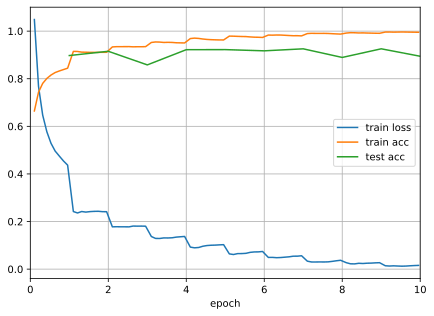

In [10]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)

##### Summary
+ Residual blocks allow for a parametrization relative to the identity function $f(\mathbf{x}) = \mathbf{x}$.
+ Adding residual blocks increases the function complexity in a well-defined manner.
+ We can train an effective deep neural network by having residual blocks pass through cross-layer data channels.
+ ResNet had a major influence on the design of subsequent deep neural networks, both for convolutional and sequential nature.

##### Exercises
1. Refer to Table 1 in the (`He et al., 2016a`) to implement different variants.
2. For deeper networks, ResNet introduces a "bottleneck" architecture to reduce model complexity. Try to implement it.
3. In subsequent versions of ResNet, the author changed the "convolution, batch normalization, and activation" architecture to the "batch normalization, activation, and convolution" architecture. Make this improvement yourself. See Figure 1 in (`He et al., 2016b`) for details.
4. Prove that if $\mathbf{x}$ is generated by a ReLU, the ResNet block does indeed include the identity function.
5. Why cannot we just increase the complexity of functions without bound, even if the function classes are nested?